In [1]:
import tensorflow as tf
import numpy as np
import dataset as ds
from random import shuffle
trainToTestRatio = 0.8

dataset = np.load('faceFeatures_9216_normalized_labels_as_coord_full_data.npz')
samples = dataset['data'].shape[0]
sampleSize = dataset['data'].shape[1]
coordsCount = dataset['y'].shape[1]
splitIdx = int(samples*trainToTestRatio)
trainData = dataset['data'][:splitIdx]
trainY = dataset['y'][:splitIdx]
testData = dataset['data'][splitIdx:]
testY = dataset['y'][splitIdx:]

resultDataset = ds.TestsetDB()


In [2]:
class Batcher:
    def __init__(self, data, labels):
        self.maxSize = data.shape[0]
        self.data = data
        self.labels = labels
        self.ni = 0
        self.idxs = list(range(self.maxSize))
        shuffle(self.idxs)
    
    def nextBatch(self, size):
        assert(size <= self.maxSize)
        
        n = self.ni
        self.ni += size
        
        if self.ni > self.maxSize:
            tailIdxs = self.idxs[n:self.maxSize]
            headIdxs = self.idxs[:self.ni-self.maxSize]
            d = np.vstack([self.data[tailIdxs], self.data[headIdxs]])
            l = np.vstack([self.labels[tailIdxs], self.labels[headIdxs]])
            self.ni = 0
            shuffle(self.idxs)
            return d, l
        else:
            return self.data[self.idxs[n:self.ni]], self.labels[self.idxs[n:self.ni]]


In [2]:
outputSize = coordsCount
x=tf.placeholder(tf.float32,shape=[None,sampleSize])
y_=tf.placeholder(tf.float32,shape=[None,outputSize])
x_96_96=tf.reshape(x,[-1,96,96,1])
w_conv1=tf.Variable(tf.truncated_normal([3,3,1,32],stddev=0.1))
b_conv1=tf.Variable(tf.constant(0.1,shape=[32]))
h_conv1=tf.nn.relu(tf.nn.conv2d(x_96_96,w_conv1,strides=[1,1,1,1],padding='SAME')+b_conv1)
h_max_pool1=tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

w_conv2=tf.Variable(tf.truncated_normal([3,3,32,64],stddev=0.1))
b_conv2=tf.Variable(tf.constant(0.1,shape=[64]))
h_conv2=tf.nn.relu(tf.nn.conv2d(h_max_pool1,w_conv2,strides=[1,1,1,1],padding='SAME')+b_conv2)
h_max_pool2=tf.nn.max_pool(h_conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

w_conv3=tf.Variable(tf.truncated_normal([2,2,64,128],stddev=0.1))
b_conv3=tf.Variable(tf.constant(0.1,shape=[128]))
h_conv3=tf.nn.relu(tf.nn.conv2d(h_max_pool2,w_conv3,strides=[1,1,1,1],padding='SAME')+b_conv3)
h_max_pool3=tf.nn.max_pool(h_conv3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

h_pool_flat=tf.reshape(h_max_pool3,[-1,12*12*128])

keep_prob = tf.placeholder(tf.float32)

w_fc1=tf.Variable(tf.truncated_normal([12*12*128,500],stddev=0.1))
b_fc1=tf.Variable(tf.constant(0.1,shape=[500]))
h_fc1=tf.nn.relu(tf.matmul(h_pool_flat,w_fc1)+b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

w_fc2=tf.Variable(tf.truncated_normal([500,500],stddev=0.1))
b_fc2=tf.Variable(tf.constant(0.1,shape=[500]))
h_fc2=tf.nn.relu(tf.matmul(h_fc1_drop,w_fc2)+b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

w_fc3=tf.Variable(tf.truncated_normal([500,30],stddev=0.1))
b_fc3=tf.Variable(tf.constant(0.1,shape=[30]))


y=tf.matmul(h_fc2_drop,w_fc3)+b_fc3

In [13]:
saver = tf.train.Saver()

In [3]:
#lossFunc = tf.nn.l2_loss(y - y_)
lossFunc = tf.sqrt(tf.reduce_mean((y - y_)**2))

train_step = tf.train.AdamOptimizer(1e-4).minimize(lossFunc)

In [ ]:
def store_sess(sess,test):
    


In [8]:
epohs = 100001
EARLY_STOPING_NUM=7


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

trainLoss = []
testLoss = []
#batcher=Batcher(trainData,trainY)
#test_batcher=Batcher(testData,testY)


for i in range(epohs):
    tD,tY=batcher.nextBatch(100)
    
    #evalY=y.eval(feed_dict={x:trainData, keep_prob: 1.0},session=sess)
    #evalY[~np.isnan(tY)]=tY[~np.isnan(tY)]
    if i % 10000 == 0:
        #tstD,tstY=batcher.nextBatch(100)
        train = lossFunc.eval(feed_dict={x:trainData, y_:trainY, keep_prob: 1.0}, session=sess)
        #evalTestY=y.eval(feed_dict={x:tstD, keep_prob: 1.0},session=sess)
        #evalTestY[~np.isnan(tstY)]=tstY[~np.isnan(tstY)]
        test = lossFunc.eval(feed_dict={x:testData, y_:testY, keep_prob: 1.0}, session=sess)
        trainLoss+=[train]
        testLoss+=[test]
        
        print('train:', train, 'test:', test)
    train_step.run(feed_dict={x:trainData, y_:trainY, keep_prob:0.5}, session=sess)

train: 6.16478 test: 6.34714
train: 0.0595538 test: 0.0565687
train: 0.0579086 test: 0.0611567
train: 0.0564226 test: 0.0515106
train: 0.054323 test: 0.0582305
train: 0.0537335 test: 0.0623527
train: 0.0581561 test: 0.0641497
train: 0.0568331 test: 0.0608612
train: 0.0580717 test: 0.0614887
train: 0.0615768 test: 0.0565248
train: 0.0558846 test: 0.0619005


In [14]:
saver.save(sess, 'cnn-3conv-3fc.ckpt')

'cnn-3conv-3fc.ckpt'

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def addFeatures(ax, features, isFill = True):
    for i in range(0, 30, 2):
        x = (features[i] + 1) * (96 / 2.0)
        y = (features[i + 1] + 1) * (96 / 2.0)
        ax.add_patch(patches.Circle((x,y),1, fill = isFill))
    
def showFace(data, features, expectedFeatures = None):
    fig,ax = plt.subplots()
    addFeatures(ax, features)
    if not expectedFeatures is None:
        addFeatures(ax, expectedFeatures, False)
    plt.imshow(data.reshape(96, 96), cmap = 'gray')

In [11]:
tData=trainData[:10]
evalResult=y.eval(feed_dict={x:tData, keep_prob:1.0}, session=sess)
testResult = lambda idx : showFace(tData[idx], evalResult[idx])

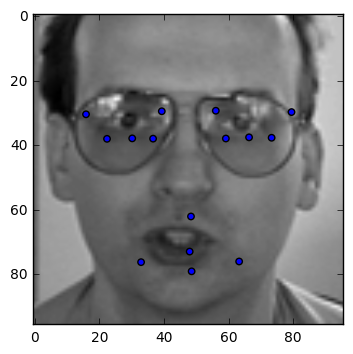

In [12]:
testResult(7)

In [40]:
evalResult[0]

array([ 0.        ,  4.26615095,  1.69389975,  3.24610782,  9.05759048,
        0.        ,  7.53118324,  7.57371998,  0.        ,  0.        ,
        6.76246405,  6.63213921,  6.7605238 ,  8.21793938,  0.97450328,
        1.96950901,  0.        ,  8.16800594,  4.86057806,  0.        ,
        3.91124845,  0.        ,  6.37740755,  2.13115859,  0.        ,
        5.63304281,  9.94185829,  0.        ,  0.        ,  0.        ], dtype=float32)